# TP2  Diabète

### 15/11/2019

Dans ce TP, on utilise la base de données diabètes de Python. Le robot malicieux ajoute 200 variables erronées mélangées aléatoirement aux 10 variables explicatives valides. On a donc 210 variables. Toutes les méthodes classiques de régression (ACP, ridge, Lasso, ...) seront abordées.

In [303]:
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from sklearn import metrics as skmetrics
from sklearn.linear_model import LinearRegression as sklearnLinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sy
from scipy.linalg import svd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import sympy
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(seed=1234)

On importe les données du fichier csv dans la dataframe df. La dernière colonne est la variable Y à expliquer. On l'enleve du dataframe. On a 442 observations (patients).

In [304]:
df = pd.read_csv('https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv',header = None)
print(df.shape)
Y = df.iloc[:,-1]  
print(Y.shape)
df = df.iloc[:,:-1]
df.shape

(442, 211)
(442,)


(442, 210)

In [305]:
# n = 442 # patients
# p = 10  # covariables valides
n = 442  # patients
p = 210  # covariables mélangées
df.head() 

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.937546,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,0.940726,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,0.338998,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.733290,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,-0.714867,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853


**442 observations et 210 variables explicatives**

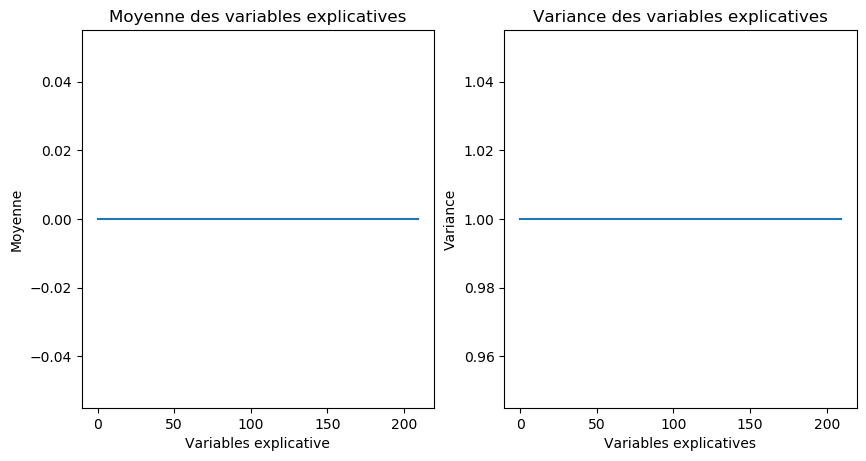

In [306]:
%matplotlib inline
# Moyennes des variables explicatives
plt.figure(1,figsize=(10,5), dpi=100)
plt.subplot(121)
plt.plot(df.mean().round())
plt.ylabel('Moyenne')
plt.xlabel('Variables explicative')
plt.title("Moyenne des variables explicatives")
# Variances des variables explicatives
plt.subplot(122)
plt.plot(df.var().round())
plt.ylabel("Variance")
plt.xlabel("Variables explicatives")
plt.title("Variance des variables explicatives")
plt.show()

On peut donc confirmer que les variables explicatives sont **normalisées** (variance = 1) et **centrées** (moyenne = 0), aux approximations près.

In [307]:
print(f"La moyenne de la variable à expliquer est de {Y.mean().round()}" \
      + f" et sa variance de {Y.var().round()}")

La moyenne de la variable à expliquer est de 152.0 et sa variance de 5943.0


La variable a expliquer n'est donc ni centrée, ni normalisée.

In [308]:
# selection de 4 covariables au hazard parmi 210 
index = np.random.randint(0, high = df.shape[1], size = 4)
df_selec = df.iloc[:, index]
df_selec.shape
df_merge = df_selec.join(Y)
df_merge.shape
df_merge.head()

,47,38,53,204,210
0,0.527538,0.014553,1.429902,-0.436399,151.0
1,-2.337870,0.659346,1.073192,1.119430,75.0
2,-0.315523,-1.076121,-0.403419,-2.579347,141.0
3,1.243353,1.040315,-0.138716,-0.884172,206.0
4,-0.289605,0.304692,0.094288,-0.642504,135.0


In [309]:
df_merge.shape[1]

5

#### On a un jeu de données parcimonieux. Autrement dit, il y a beaucoup de variables qui ne servent à rien. C'est à dire qu'elles ne sont pas vraiment explicatives. 

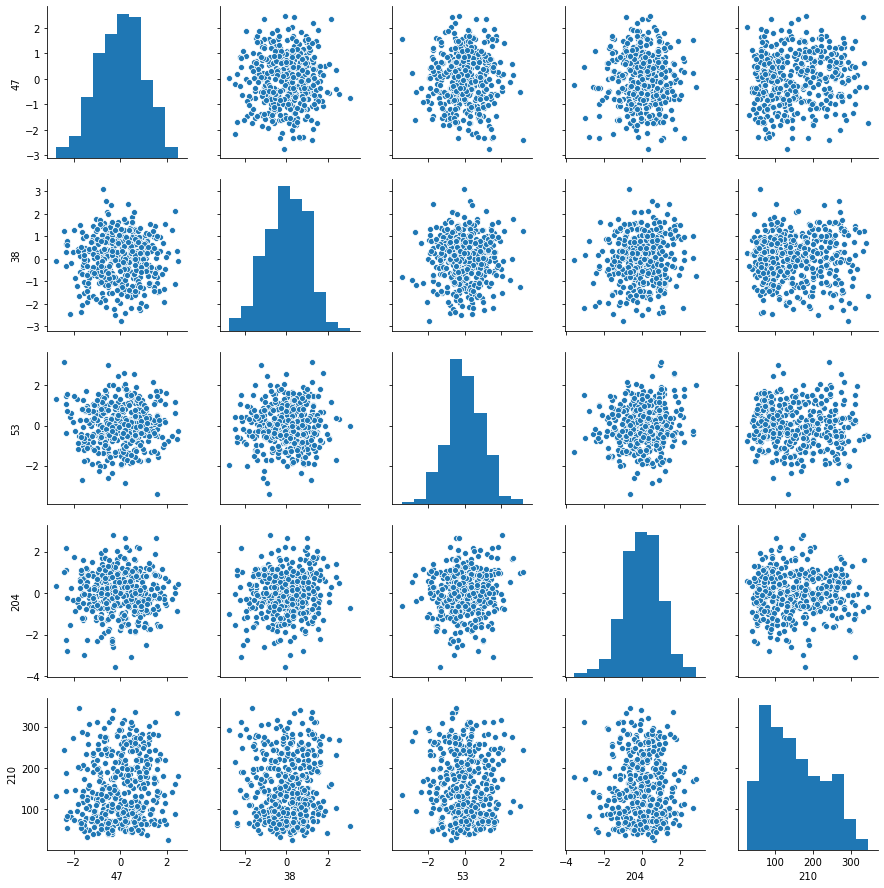

In [310]:
sns.pairplot(df_merge)

Les variables explicatives prises au hasard présentent des distributions gausiennes. Elles ne semblent pas présenter de relation entre elles : elles sont décorrélées. La dernière variable, i.e. la variable à expliquer, ne présente pas de distribution gaussienne.  

### Création de deux échantillons

In [311]:
dfa = df.join(Y) # inclus la variable à expliquer Y -> y_test, y_train
x_train, x_test = train_test_split(dfa, test_size=0.2) 

In [312]:
y_test  = x_test.iloc[:,-1]    # Extraction de la variable à expliquer
y_train = x_train.iloc[:,-1]   # Extraction de la variable à expliquer
x_train = x_train.iloc[:,0:x_train.shape[1]-1]
x_test  = x_test.iloc[:,0:x_test.shape[1]-1]

In [313]:
print(f"La moyenne de la variable y_test à expliquer est de {y_test.mean().round()}" \
      + f" et sa variance de {y_test.var().round()}")
print(f"La moyenne de la variable y_train à expliquer est de {y_train.mean().round()}" \
      + f" et sa variance de {y_train.var().round()}")

La moyenne de la variable y_test à expliquer est de 150.0 et sa variance de 5691.0
La moyenne de la variable y_train à expliquer est de 153.0 et sa variance de 6022.0


In [314]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((353, 210), (353,), (89, 210), (89,))

In [315]:
print("La taille de l'échantillon pour entrainer le modèle est {:.0f} .".format(len(x_train)))
print("La taille de l'échantillon pour tester le modèle la taille est {:.0f} .".format(len(x_test)))

La taille de l'échantillon pour entrainer le modèle est 353 .
La taille de l'échantillon pour tester le modèle la taille est 89 .


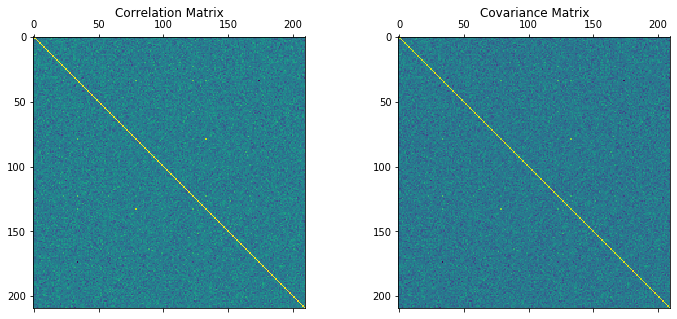

In [316]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].matshow(x_train.corr())
axes[0].set_title('Correlation Matrix')
axes[1].matshow(x_train.cov())
axes[1].set_title('Covariance Matrix')
plt.show()

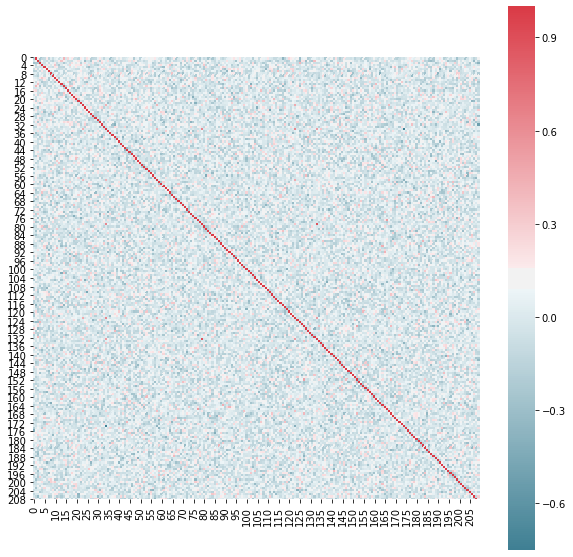

In [317]:
f, ax = plt.subplots(figsize=(10, 10))
corr = x_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [318]:
cov = x_train.cov()
# SVD
U, s, VT = svd(corr)
print(U.shape)
print(VT.shape)
print(s.shape)

(210, 210)
(210, 210)
(210,)


On fait la décompositions en valeurs singulières de la matrice de corrélation calculée sur l'échantillon d'apprentissage x_train. Compte-tenu des valeurs propres observées, on constate que l'OLS ne va pas bien marcher. On va utiliser l'ACP, c'est à dire ne garder que les composantes principales. Autrement dit, on va tronquer le spectre afin de ne garder que les plus grandes valeurs propres.

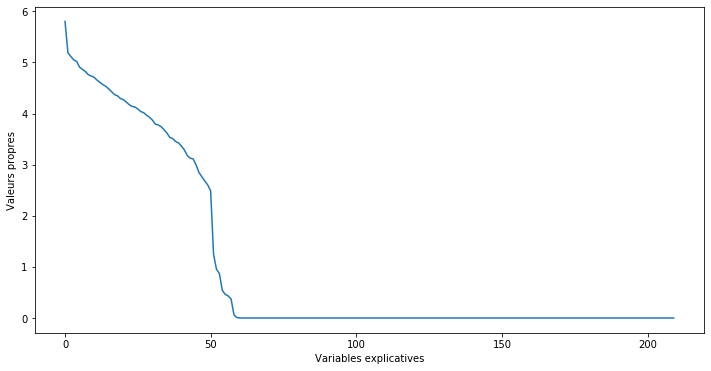

In [319]:
plt.figure(figsize=(12, 6))
ss = np.sort(s)[::-1]
plt.plot(ss)
plt.ylabel("Valeurs propres")
plt.xlabel("Variables explicatives")
plt.show()

On ne garde que les variables explicatives avec les 60 plus grandes valeurs propres. Autrement dit, on ne garde que les valeurs propres qui ne sont pas proches de zéro, ce qui correspond à **ne garder que les directions qui maximise la variance projetée.** <br/>

Les directions principales sont les directions selon lesquelles on maximise la variabilité. On enlève les directions selon lesquelles la variation est petite. Le fait d'enlever des directions dans l'ACP présente un aspect défavorable en ce sens que l'**on perd de l'information**. <br/>

Il est important de compresser les données en ne gardant que des variables explicatives correspondant aux valeurs propres les plus fortes car cela permet d'**améliorer le conditionnement** (rapport de la valeur propre la plus forte sur la plus faible) de la matrice de Gram à inverser. Les variables sont sélectionnées pour leur forte dispersion, cela ne tient en revanche pas compte de l'indépendance des variables. <br/>

Par conséquent, l'ACP consiste à tronquer et ne garder que les valeurs propres pas trop faibles. Dans ce cas on dégrade un peu les données, mais on va favoriser l'estimateur.

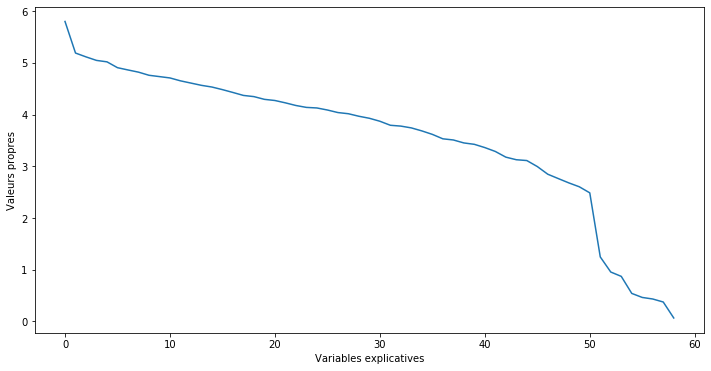

In [320]:
bigger_eig = ss[0:59]
plt.figure(figsize=(12, 6))
plt.plot(bigger_eig)
plt.ylabel("Valeurs propres")
plt.xlabel("Variables explicatives")
plt.show()

In [321]:
# OLS
regr = sklearnLinearRegression()     
regr.fit(x_train, y_train)
y_pred_tmp = np.dot(x_test , regr.coef_ )
y_pred = y_pred_tmp +  regr.intercept_ 
y_pred = regr.predict(x_test)

In [322]:
# Projection sur les vecteur propres des 60 vp les plus fortes
x_train_tilde = np.dot( x_train, np.transpose(VT[:60]) )
regrPCA = sklearnLinearRegression()     
regrPCA.fit(x_train_tilde, y_train)
x_test_tilde = np.dot( x_test, np.transpose(VT[:60]) )
x_train_tilde.shape, y_train.shape, x_test_tilde.shape, regrPCA.coef_.shape
y_predPCA_tmp = np.dot(x_test_tilde, regrPCA.coef_)
y_predPCA = y_predPCA_tmp +  regrPCA.intercept_ 

print('OLS :') 
print("Intercept = %.2f" % regr.intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Risque de prédiction du modèle = %.2f" % mse)
R2_score = r2_score(y_test, y_pred)
print('Coefficient de détermination du modèle = %.2f' % R2_score)
print('=================================================')
print('PCA before OLS :') 
print("Intercept = %.2f" % regrPCA.intercept_)
mse_pca = mean_squared_error(y_test, y_predPCA)
print("Risque de prédiction du modèle = %.2f" % mse_pca)
R2_score_pca = r2_score(y_test, y_predPCA)
print('Coefficient de détermination du modèle = %.2f' % R2_score_pca)

OLS :
Intercept = 150.17
Risque de prédiction du modèle = 4481.24
Coefficient de détermination du modèle = 0.20
PCA before OLS :
Intercept = 151.04
Risque de prédiction du modèle = 4166.05
Coefficient de détermination du modèle = 0.26


Les deux intercepts des deux estimateurs sont bien égaux à la valeur moyenne de la variable Y sur l'échantillon d'entrainement. Avec un risque de prédiction plus faible et un meilleur coefficient de détermination, on constate bien une **meilleure qualité d'estimateur pour le PCA avant OLS.** 

In [323]:
print('Valeur moyenne de la variable Y sur l\'échantillon d\'entrainement = %.2f' % y_train.mean())

Valeur moyenne de la variable Y sur l'échantillon d'entrainement = 152.64


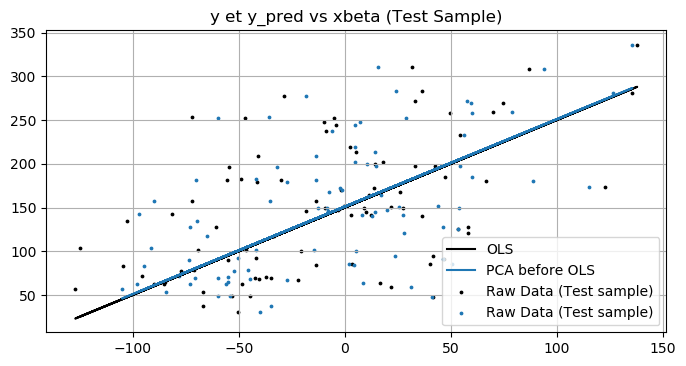

In [324]:
%matplotlib inline
plt.figure(figsize=(8,4), dpi=100) 
plt.plot(y_pred_tmp , y_pred, label='OLS', color = 'black')
plt.scatter(y_pred_tmp, y_test, s = 3, label='Raw Data (Test sample)', color = 'black')
plt.plot(y_predPCA_tmp , y_predPCA, label='PCA before OLS')
plt.scatter(y_predPCA_tmp, y_test, s = 3, label='Raw Data (Test sample)')
plt.title("y et y_pred vs xbeta (Test Sample)")
plt.legend()
plt.grid(True)
plt.show()

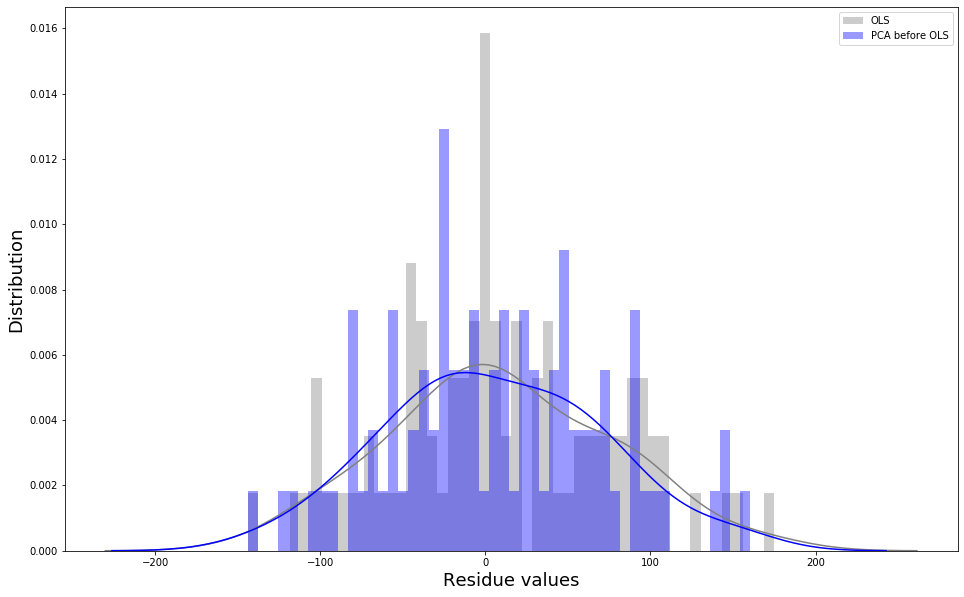

In [325]:
r_i    =  y_test - y_pred
r_iPCA =  y_test - y_predPCA
# distribution histogram of the residus
fig6 = plt.figure(figsize=(16,10))
plt.tight_layout()
sns.distplot(r_i,label='OLS',color='grey',bins=50)
sns.distplot(r_iPCA,label='PCA before OLS',color='blue',bins=50)
plt.ylabel("Distribution", fontsize=18)
plt.xlabel("Residue values", fontsize=18)
plt.legend()
plt.show()

On observe bien une distribution des résidus centrée en zéro.

On code la méthode de forward sélection. Dans cette méthode, à chaque itération, on selectionne la variable avec la plus grande p-valeur.

In [326]:
def forward_variable_selection(X, Y, stop_criterion=False, threshold=0.1):
    """Méthode de forward variable sélection en utilisant la loi de student pour calculer les stat de test
    X: array des covariables de l'échantillon training
    Y: array formée par la variable à expliquer
    """
    n = X.shape[0]
    select_var = []
    select_p_valeur = []
    select_t_stat = []
    X = np.append(np.ones((len(X),1)), X, axis=1)
    i = 0
    test = np.zeros((X.shape[1],X.shape[1]))
    pval = np.zeros((X.shape[1],X.shape[1]))

    while len(select_var) <= X.shape[1]-1:
        p_valeur = []
        t_statistique = []
        residual = []

        for j in range(X.shape[1]):
            if j not in select_var:

                Xj = X[:, j]

                thetaj = 1 / (Xj.T @ Xj) * Xj.T @ Y
                Y_pred = Xj * thetaj
                sigma2j = (Y - Y_pred).T @ (Y - Y_pred) / (n - 1)
                sigma_thetaj = np.sqrt(sigma2j * 1 / (Xj.T @ Xj))
                t_statistiquej = thetaj / sigma_thetaj
                p_valeurj = (1 - stats.t.cdf(abs(t_statistiquej), n - 1)) * 2                            

                p_valeur.append(p_valeurj)
                t_statistique.append(t_statistiquej)                

                residual.append(Y - Y_pred)

            else:
                p_valeur.append(1.1)
                residual.append(0)
                t_statistique.append(0)

        test[:,i] = t_statistique                
        pval[:,i] = p_valeur
        
        imin = np.argmin(p_valeur)
        Y = residual[imin]
        select_var.append(imin)
        select_p_valeur.append(p_valeur[imin])
        select_t_stat.append(t_statistique[imin])

        if stop_criterion == True and p_valeur[imin] > threshold:
            return np.transpose(select_var[1:-1]) - 1, np.transpose(select_p_valeur)[:-1]
            break
                
        i+=1

    return np.transpose(select_var[1:]) - 1, np.transpose(select_p_valeur), test

In [327]:
select_var, select_p_valeur, test = forward_variable_selection(np.array(x_train), np.array(y_train), False)
print(f"Affichage dans l'ordre des variables sélectionnées par l'algorithme de forward variable selection (sans intercept): \
      \n \n {var_sel}")

Affichage dans l'ordre des variables sélectionnées par l'algorithme de forward variable selection (sans intercept):       
 
 [0, 59, 124, 111, 28, 46, 128, 32, 53, 100, 24, 122, 78, 163, 31, 194, 168, 109, 51, 104, 67, 191, 108, 43, 171, 27, 185, 203, 13, 20, 177, 153, 174, 89, 192, 7, 120, 119, 95, 40, 21, 178, 152, 155, 60, 35, 80, 167, 44, 180, 169, 94, 173, 206, 34, 29, 175, 136, 160, 183, 165, 210, 112, 74, 113, 123, 88, 205, 52, 54, 181, 144, 26, 197, 86, 143, 58, 158, 133, 137, 103, 172, 49, 130, 1, 179, 184, 66, 81, 201, 147, 8, 6, 154, 198, 18, 156, 204, 115, 61, 82, 38, 196, 126, 92, 4, 62, 101, 189, 106, 64, 25, 135, 12, 146, 39, 139, 200, 161, 65, 9, 22, 37, 125, 30, 98, 107, 50, 75, 138, 85, 199, 83, 96, 195, 73, 97, 10, 5, 99, 131, 116, 87, 132, 70, 71, 23, 164, 149, 134, 105, 36, 55, 207, 159, 129, 170, 110, 69, 176, 2, 114, 41, 33, 93, 90, 118, 42, 202, 45, 157, 166, 121, 190, 188, 79, 16, 77, 91, 68, 145, 3, 117, 56, 102, 148, 193, 84, 186, 57, 150, 63, 14, 162, 47, 2

Pour les 3 premières étapes de la méthode (k=0,1,2), on trace les valeurs de la statistique de test.

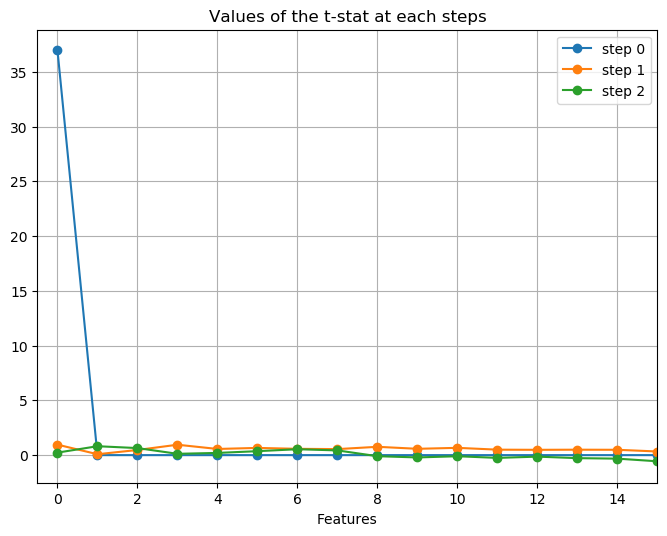

In [328]:
def foo(s1):
    return "step %s" % s1
%matplotlib inline
plt.figure(figsize=(8,6), dpi=100) 
for k in range(3): 
    lab_tmp = foo(k)
    plt.plot(np.arange(test.shape[1]), test[k,:], '-o',label = lab_tmp)
    plt.gca().set_xlim(xmin = -.5, xmax = 15)
#    plt.axis(xmin = -.5, xmax = 9.5, ymin = -1)
plt.legend(loc='upper right')
plt.title("Values of the t-stat at each steps")
plt.xlabel("Features")
plt.grid()
plt.show()

In [329]:
select_var_stop, select_p_valeur_stop = forward_variable_selection(np.array(x_train), np.array(y_train), True)
print(f"Variables sélectionnées par l'algorithme de forward variable selection avec critère d'arrêt: \
      \n \n {select_var_stop}")

Variables sélectionnées par l'algorithme de forward variable selection avec critère d'arrêt:       
 
 [ 34  58  79 167 135 123 129  13  81  54 174]


On peut maintenant regarder, pour chaque étape, la p-valeur associée à la variable sélectionnée. La p-valeur croît à chaque itération et si l'on se fixe un niveau de 0.1, **on rejette l'hypothèse nulle ($H_0$ : $\beta_k = 0$) uniquement pour les M premières étapes,**

In [330]:
M = len(select_var_stop)
print("avec M = ", M)

avec M =  11


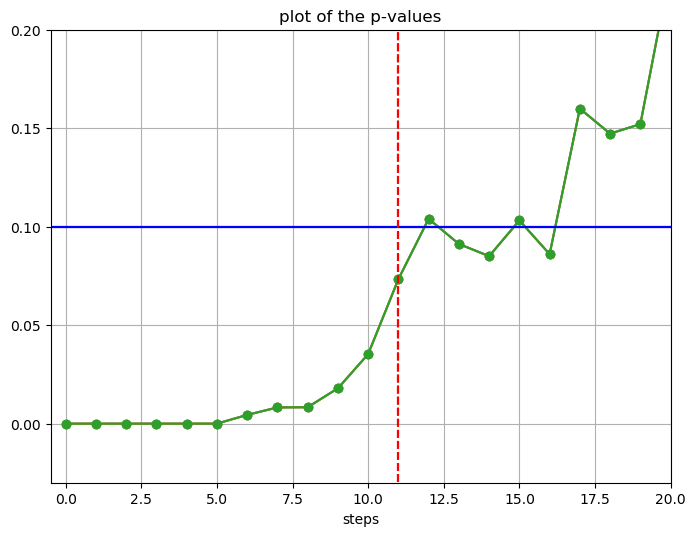

In [331]:
%matplotlib inline
plt.figure(figsize=(8,6), dpi=100) 
for k in range(3): 
    plt.plot(np.arange(test.shape[1]),select_p_valeur, 'o-')
    plt.plot([-0.5,20],[.1,.1],color = "blue" )
    plt.plot([M,M],[-.1,20],'--', color = "red" )
    plt.axis(xmin = -.5,xmax = 20,ymin = -.03, ymax = 0.2)
plt.title("plot of the p-values")
plt.xlabel("steps")
plt.grid()
plt.show()

In [332]:
x_train_forward = x_train.iloc[:,select_var_stop]
x_test_forward = x_test.iloc[:,select_var_stop]

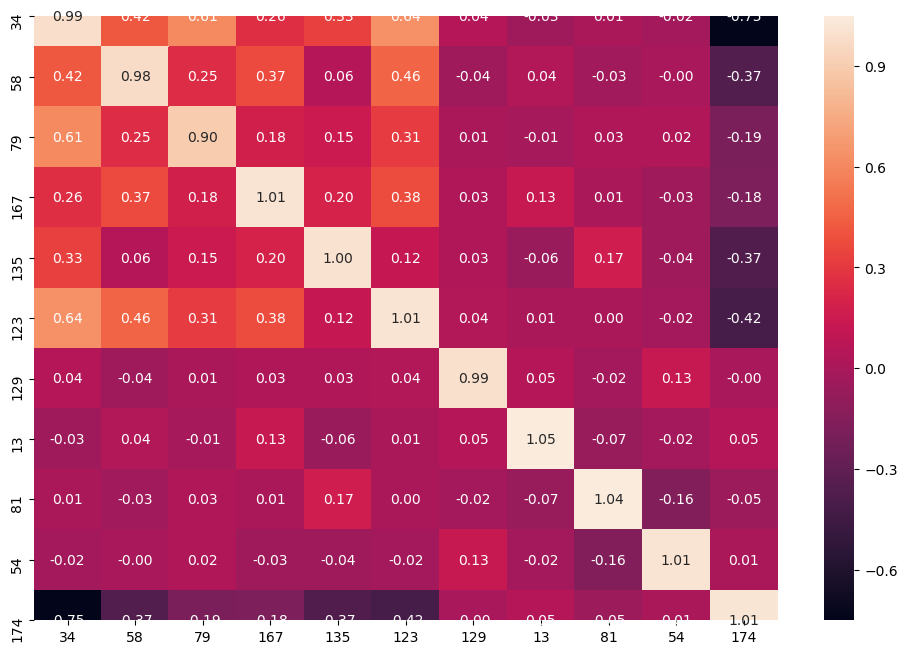

In [333]:
# Matrice de covariance de x_train_forward
%matplotlib inline
plt.figure(figsize=(12,8), dpi=100) 
sns.heatmap(x_train_forward.cov(), annot=True, fmt=".2f")
plt.show()

## OLS sur variables sélectionnées par forward

In [334]:
def calc_reg_model_coefficients(x_train, y_train, model):
    '''calcule les coefficients de régression du modèle linéaire'''    
    model.fit(x_train, y_train)
    theta0_skl = model.intercept_
    theta_skl = model.coef_
    return theta0_skl, theta_skl

def calc_residual(X_train, y_train, X_test, y_test, model):
    '''calcule les résidus de la prédiction'''
    model.fit(X_train, y_train)
    return model.predict(X_test) - y_test

def calc_R2score(X_train, y_train, X_test, y_test, model):
    '''calcule le coefficient de détermination'''
    model.fit(X_train, y_train)
    R2_score = r2_score(y_test, model.predict(X_test), multioutput='variance_weighted')    
    return R2_score

def calc_error_metrics(X_train, y_train, X_test, y_test, model):
    '''fitte le modèle et donne les risques de prédiction sur les échantillons train et test'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

def calc_train_error(X_train, y_train, model):
    ''' calcule le risque de prédiction sur l'échantillon train'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    return mse

def calc_validation_error(X_test, y_test, model):
    ''' calcule le risque de prédiction sur l'échantillon test'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [335]:
# Régression linéaire avec scikit-learn
theta0_forward_skl = calc_reg_model_coefficients(x_train_forward, y_train, sklearnLinearRegression(fit_intercept = True))[0]
theta_forward_skl = calc_reg_model_coefficients(x_train_forward, y_train, sklearnLinearRegression(fit_intercept = True))[1]

# Calcul du résidu de la variable à expliquer pour l'échantillon test
residual_forward = calc_residual(x_train_forward, y_train, x_test_forward, y_test, sklearnLinearRegression(fit_intercept = True))

# Coefficient de détermination
R2_score_forward = calc_R2score(x_train_forward, y_train, x_test_forward, y_test, sklearnLinearRegression(fit_intercept = True))
print(f" Le coefficient de détermination est de {round(R2_score_forward,3)}")

# Risque de prédiction
mse_forward = calc_error_metrics(x_train_forward, y_train, x_test_forward, y_test, sklearnLinearRegression(fit_intercept = True))[1]
print(f" Le risque de prédiction est de {round(mse_forward,3)}")


 Le coefficient de détermination est de 0.333
 Le risque de prédiction est de 3752.556


## Comparaison des modèles

In [336]:
# Coefficients de détermination pour les régressions réalisées
print(' |  R2score PCA before OLS  |  R2score OLS  |  R2score forward  |')
print(' -------------------------------------------------------------')
print(f" |            {round(R2_score_pca,3)}         |      {round(R2_score,3)}    |       {round(R2_score_forward,3)}       |")

 |  R2score PCA before OLS  |  R2score OLS  |  R2score forward  |
 -------------------------------------------------------------
 |            0.26         |      0.204    |       0.333       |


In [337]:
# Valeurs des risques de prédiction pour les régressions réalisées
print(' |  Risque PCA before OLS  |  Risque OLS  |  Risque forward  |')
print(' -------------------------------------------------------------')
print(f" |           {round(mse_pca,3)}        |   {round(mse,3)}   |     {round(mse_forward,3)}     |")

 |  Risque PCA before OLS  |  Risque OLS  |  Risque forward  |
 -------------------------------------------------------------
 |           4166.048        |   4481.24   |     3752.556     |


In [338]:
# Séparation de l'échantillon train en 4 parties
K = 4
kf = KFold(n_splits=K, shuffle=True, random_state=1)
data = x_train
target = y_train
i = 1

dict_index_folds = {}

for train_index, fold_index in kf.split(data, target):        
    dict_index_folds[f'Fold {i}'] = np.asarray(x_train.iloc[fold_index].index)
    
    # split des données
    x_train_cv, x_fold_cv = data.iloc[train_index], data.iloc[fold_index]
    y_train_cv, y_fold_cv = target.iloc[train_index], target.iloc[fold_index]
    i += 1

# Affichage du dictionnaire contenant les indices des échantillons contenus dans chaque fold    
dict_index_folds

{'Fold 1': array([205, 401, 203,  24, 312, 335,  70, 268, 349, 194, 322, 156, 153,
        181,  20, 144, 234, 132,   6, 386, 423, 188, 125, 228, 426,  80,
        193, 265, 266, 429,  17, 414, 317, 247, 260,  51, 245, 185,  94,
        351,  32, 209, 357, 217, 147,  87, 288, 210,  98, 145, 257,  49,
        327,  75,   8, 274, 291, 170,  46, 130,  15, 136, 406, 286, 277,
        121, 334, 311, 345, 103,   4, 284, 417, 431, 328,  45,  84,  89,
        113, 343, 243, 107, 139,  76, 368, 171, 177, 143, 372]),
 'Fold 2': array([333, 364, 289, 140, 366, 141, 400, 227, 375, 356, 296, 108,  99,
        219, 298, 101, 377, 337, 229, 319, 434, 110, 421, 350, 192, 418,
        361, 134,  53, 162, 394, 157,  77, 395, 270, 310, 124, 299, 318,
        127, 137, 112,  83,  60, 339,  65,  35,  39,  19, 332,  12,  28,
        164, 384, 126, 398, 212,  88, 313,  79, 320,  68, 259, 142, 346,
        256,  34, 175, 294,  18, 438, 303,  86,  41, 249, 197, 269, 316,
        331, 436, 240,  50, 246, 383, 3

## Validation croisée

In [339]:
alphas = [0.0001,0.0003,0.0006,
          0.001,0.003,0.006,
          0.01,0.03,0.06,
          0.1,0.3,0.6,
          1,3,6,
          10,30,60,
          100,300,600,
          1000,3000,6000]

mean_train_errors = []
mean_fold_errors = []
for alpha in alphas:
    train_errors = []
    fold_errors = []
    for train_index, fold_index in kf.split(data, target):
        
        # split des données
        X_train_cv, X_fold_cv = data.iloc[train_index], data.iloc[fold_index]
        y_train_cv, y_fold_cv = target.iloc[train_index], target.iloc[fold_index]

        # modèle
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        
        #calcul des erreurs
        train_error_cv, fold_error_cv = calc_error_metrics(X_train_cv, y_train_cv, X_fold_cv, y_fold_cv, ridge)
        
        # append to appropriate list
        train_errors.append(train_error_cv)
        fold_errors.append(fold_error_cv)
    
    # generate report
    print('alpha: {:6} | mean(train_error_cv): {:7} | mean(fold_error_cv): {}'.
          format(alpha,
                 round(np.mean(train_errors),3),
                 round(np.mean(fold_errors),3)))
    
    mean_train_errors.append(round(np.mean(train_errors),3))
    mean_fold_errors.append(round(np.mean(fold_errors),3))
    

alpha: 0.0001 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.418
alpha: 0.0003 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.412
alpha: 0.0006 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.404
alpha:  0.001 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.393
alpha:  0.003 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.338
alpha:  0.006 | mean(train_error_cv): 2147.16 | mean(fold_error_cv): 3764.256
alpha:   0.01 | mean(train_error_cv): 2147.161 | mean(fold_error_cv): 3764.147
alpha:   0.03 | mean(train_error_cv): 2147.165 | mean(fold_error_cv): 3763.613
alpha:   0.06 | mean(train_error_cv): 2147.177 | mean(fold_error_cv): 3762.841
alpha:    0.1 | mean(train_error_cv): 2147.204 | mean(fold_error_cv): 3761.863
alpha:    0.3 | mean(train_error_cv): 2147.487 | mean(fold_error_cv): 3757.679
alpha:    0.6 | mean(train_error_cv): 2148.168 | mean(fold_error_cv): 3752.916
alpha:      1 | mean(train_error_cv): 2149.241 | mean(fold

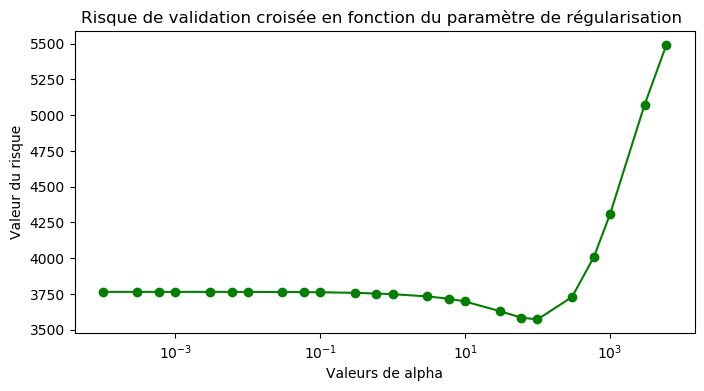

In [340]:
%matplotlib inline

plt.figure(figsize=(8,4), dpi=100) #10 unites dans un sens, 4 dans l'autre
plt.plot(alphas, mean_fold_errors, '-og', label = 'Validation')        
plt.title("Risque de validation croisée en fonction du paramètre de régularisation ")
plt.xlabel("Valeurs de alpha")
plt.ylabel("Valeur du risque")
plt.xscale('log')
plt.show()

In [341]:
# Paramètre optimal de régularisation
alpha_ridge = alphas[np.argmin(mean_fold_errors)]
print('Le paramètre de régularisation optimal est : {}'.format(alpha_ridge))
print('La valeur du risque associée à ce paramètre de régularisation est : {}'.format(np.min(mean_fold_errors)))

Le paramètre de régularisation optimal est : 100
La valeur du risque associée à ce paramètre de régularisation est : 3571.914


## Comparaison des modèles

In [342]:
# Coefficient de détermination
R2_score_ridge = calc_R2score(x_train, y_train, x_test, y_test, Ridge(alpha=alphas[np.argmin(mean_fold_errors)], fit_intercept=True))
print(f" Le coefficient de détermination est de {round(R2_score_ridge,3)}")

# Risque de prédiction
mse_ridge = calc_error_metrics(x_train, y_train, x_test, y_test, Ridge(alpha=alphas[np.argmin(mean_fold_errors)], fit_intercept=True))[1]
print(f" Le risque de prédiction est de {round(mse_ridge,3)}")


 Le coefficient de détermination est de 0.302
 Le risque de prédiction est de 3928.729


In [343]:
# Coefficients de détermination pour les régressions réalisées
print(' |  R2score PCA before OLS  |  R2score OLS  |  R2score forward  |  R2score ridge  |')
print(' ----------------------------------------------------------------------------------')
print(f" |            {round(R2_score_pca,3)}         |      {round(R2_score,3)}    |       {round(R2_score_forward,3)}       |      {round(R2_score_ridge,3)}      |")

 |  R2score PCA before OLS  |  R2score OLS  |  R2score forward  |  R2score ridge  |
 ----------------------------------------------------------------------------------
 |            0.26         |      0.204    |       0.333       |      0.302      |


In [344]:
# Valeurs des risques de prédiction pour les régressions réalisées
print(' |  Risque PCA before OLS  |  Risque OLS  |  Risque forward  |  Risque ridge  |')
print(' ------------------------------------------------------------------------------')
print(f" |           {round(mse_pca,3)}        |   {round(mse,3)}   |     {round(mse_forward,3)}     |     {round(mse_ridge,3)}   |")

 |  Risque PCA before OLS  |  Risque OLS  |  Risque forward  |  Risque ridge  |
 ------------------------------------------------------------------------------
 |           4166.048        |   4481.24   |     3752.556     |     3928.729   |


## Lasso CV

In [345]:
# Modèle LassoCV de sklearn
model_lasso = LassoCV().fit(x_train,y_train)

# Paramètre optimal de régularisation
alpha_lasso = model_lasso.alpha_
print(f"Le paramètre optimal de régularisation pour le Lasso est : {round(alpha_lasso,3)}")

# Risque de prédiction
mse_lasso = calc_error_metrics(x_train, y_train, x_test, y_test, LassoCV().fit(x_train,y_train))[1]
print(f"Le risque de prédiction est de {round(mse_lasso,3)}")

# Coefficient de détermination
R2_score_lasso = calc_R2score(x_train, y_train, x_test, y_test, LassoCV().fit(x_train,y_train))
print(f"Le coefficient de détermination est de {round(R2_score_lasso,3)}")


Le paramètre optimal de régularisation pour le Lasso est : 6.354
Le risque de prédiction est de 3544.485
Le coefficient de détermination est de 0.37


## Comparaison des modèles

In [346]:
# Coefficients de détermination pour les régressions réalisées
print(' |  R2score PCA |  R2score OLS  |  R2score forward  |  R2score ridge  |  R2score Lasso  |')
print(' ----------------------------------------------------------------------------------------')
print(f" |     {round(R2_score_pca,3)}    |      {round(R2_score,3)}    |       {round(R2_score_forward,3)}       |      {round(R2_score_ridge,3)}      |       {round(R2_score_lasso,3)}      |")

 |  R2score PCA |  R2score OLS  |  R2score forward  |  R2score ridge  |  R2score Lasso  |
 ----------------------------------------------------------------------------------------
 |     0.26    |      0.204    |       0.333       |      0.302      |       0.37      |


In [347]:
# Valeurs des risques de prédiction pour les régressions réalisées
print(' |  Risque PCA |  Risque OLS  |  Risque forward  |  Risque ridge  |  Risque Lasso  |')
print(' -----------------------------------------------------------------------------------')
print(f" |    {round(mse_pca,3)}   |   {round(mse,3)}   |     {round(mse_forward,3)}     |     {round(mse_ridge,3)}   |     {round(mse_lasso,3)}   |")

 |  Risque PCA |  Risque OLS  |  Risque forward  |  Risque ridge  |  Risque Lasso  |
 -----------------------------------------------------------------------------------
 |    4166.048   |   4481.24   |     3752.556     |     3928.729   |     3544.485   |


## Coefficient sélectionnés par Lasso

In [348]:
# Coefficients provenant du Lasso
coef_lasso = model_lasso.coef_
select_var_lasso = np.asarray(np.nonzero(coef_lasso))[0]

print(f"Il y a {len(select_var_lasso)} variables selectionnées par le Lasso, qui sont: \
      \n \n {select_var_lasso}")

Il y a 10 variables selectionnées par le Lasso, qui sont:       
 
 [ 13  23  58  85 123 129 135 167 174 206]


## OLS appliquée à Lasso

In [351]:
## OLS appliquée à Lasso
x_train_lasso = x_train.iloc[:,select_var_lasso]
x_test_lasso = x_test.iloc[:,select_var_lasso]

# Régression linéaire avec scikit-learn
theta0_LSlasso_skl = calc_reg_model_coefficients(x_train_lasso, y_train, sklearnLinearRegression(fit_intercept = True))[0]
theta_LSlasso_skl = calc_reg_model_coefficients(x_train_lasso, y_train, sklearnLinearRegression(fit_intercept = True))[1]

# Calcul du résidu de la variable à expliquer pour l'échantillon test
residual_LSlasso = calc_residual(x_train_lasso, y_train, x_test_lasso, y_test, sklearnLinearRegression(fit_intercept = True))

# Coefficient de détermination
R2_score_LSlasso = calc_R2score(x_train_lasso, y_train, x_test_lasso, y_test, sklearnLinearRegression(fit_intercept = True))
print(f" Le coefficient de détermination est de {round(R2_score_LSlasso,3)}")

# Risque de prédiction
mse_LSlasso = calc_error_metrics(x_train_lasso, y_train, x_test_lasso, y_test, sklearnLinearRegression(fit_intercept = True))[1]
print(f" Le risque de prédiction est de {round(mse_LSlasso,3)}")

 Le coefficient de détermination est de 0.321
 Le risque de prédiction est de 3818.755


## Comparaison des modèles

In [352]:
# Coefficients de détermination pour les régressions réalisées
print(' |  R2score PCA |  R2score OLS  |  R2score forward  |  R2score ridge  |  R2score Lasso  |  R2score LSLasso  |')
print(' ------------------------------------------------------------------------------------------------------------')
print(f" |     {round(R2_score_pca,3)}    |      {round(R2_score,3)}    |       {round(R2_score_forward,3)}       |      {round(R2_score_ridge,3)}      |       {round(R2_score_lasso,3)}      |        {round(R2_score_LSlasso,3)}      |")

 |  R2score PCA |  R2score OLS  |  R2score forward  |  R2score ridge  |  R2score Lasso  |  R2score LSLasso  |
 ------------------------------------------------------------------------------------------------------------
 |     0.26    |      0.204    |       0.333       |      0.302      |       0.37      |        0.321      |


In [353]:
# Valeurs des risques de prédiction pour les régressions réalisées
print(' |  Risque PCA |  Risque OLS  |  Risque forward  |  Risque ridge  |  Risque Lasso  |  Risque LSLasso  |')
print(' ------------------------------------------------------------------------------------------------------')
print(f" |    {round(mse_pca,3)}   |   {round(mse,3)}   |     {round(mse_forward,3)}     |     {round(mse_ridge,3)}   |     {round(mse_lasso,3)}   |      {round(mse_LSlasso,3)}    |")

 |  Risque PCA |  Risque OLS  |  Risque forward  |  Risque ridge  |  Risque Lasso  |  Risque LSLasso  |
 ------------------------------------------------------------------------------------------------------
 |    4166.048   |   4481.24   |     3752.556     |     3928.729   |     3544.485   |      3818.755    |


Voici l'ordre de performance de toutes les approches du modèle linéaire testées (de la plus performante à la moins performante): 

## Lasso > Forward > LS Lasso > Ridge > PCA before OLS  > OLS classique

L'échantillon est trop petit pour voir une différence significative entre les estimateurs. Enfin, on peut tester les arbres de forêts aléatoires.

In [363]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

In [364]:
from sklearn.model_selection import cross_val_score
scores = -cross_val_score(my_pipeline, x_train_forward, y_train, scoring='neg_mean_squared_error')
print(scores)

[2843.5359322  4104.65610169 3573.07179487]


In [365]:
scores

array([2843.5359322 , 4104.65610169, 3573.07179487])

In [366]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
333,0.037622,1.614333,1.040906,-0.837319,0.156725,-0.008940,0.961808,-0.712651,1.480447,-1.224102,...,0.529877,-0.329096,-0.499377,-0.694621,-0.462798,-0.509487,0.083208,1.191687,0.026112,0.141279
387,-0.197056,0.128991,2.092616,-0.252120,0.626673,0.390725,-0.092878,0.490140,0.199732,-1.718705,...,0.623029,-0.053464,0.622657,-0.720796,-0.276843,-0.513393,1.034089,-0.070567,-0.920799,-1.850177
186,1.321174,0.725761,-0.401913,-1.579855,-0.148699,-0.232025,-0.194308,-1.270854,0.366110,-0.811150,...,-0.230395,0.996789,0.519521,-1.931578,0.130823,1.928564,2.040921,0.980196,0.176042,0.310037
378,1.176881,-0.936731,-1.024180,-0.218501,1.205586,-0.218614,-0.798692,0.110987,0.444392,1.688126,...,0.848219,0.718459,2.031046,-0.610533,1.121595,-0.245430,-1.917641,-0.071446,0.123140,0.296448
205,0.019797,-1.410462,-0.102317,-1.133274,0.152617,-0.189487,-0.348912,1.155174,0.356731,0.920597,...,1.128377,-0.037873,0.101765,0.656656,0.692623,1.204293,0.530375,-0.179802,0.190584,1.757396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,-0.815864,-1.638798,-1.989795,2.970273,0.019830,-0.618426,1.028954,-0.082559,1.422939,0.239962,...,1.103016,0.320246,0.239499,-0.502955,-0.656950,-0.945119,-0.395594,0.147651,-1.187099,-0.272255
177,-0.457299,1.038143,0.411974,0.391127,-1.449583,-0.070531,0.522769,0.478446,-0.425931,-0.091851,...,-1.518803,-0.626462,0.101773,0.077881,0.387317,-0.313765,-0.863498,-0.523496,0.945439,-0.503273
143,0.080663,-1.579852,-0.239570,0.778827,-1.086684,-0.497007,-1.482206,0.888714,1.334286,-0.462729,...,-0.251689,2.057942,0.512752,0.468414,-1.272816,0.122151,-0.471402,-1.115631,0.523538,0.883751
152,-0.453374,0.416663,0.335465,-0.073340,1.109669,0.543146,0.108420,-0.491734,-2.044500,0.468645,...,-0.903056,0.091650,0.125334,-2.501783,-0.105855,-1.572060,0.248935,0.051543,0.108825,0.839944
